# Postprocess

In [10]:
%matplotlib inline

In [4]:
from glob import glob
import xarray as xr

In [2]:
topdirs = ['/global/cscratch1/sd/crjones/for_fengfei/e3sm-mmf/',
           '/global/cscratch1/sd/crjones/for_fengfei/e3sm/']
years = [('0002', '0003', '0004', '0005', '0006', '0007'), ('0001', '0002', '0003')]
prefixes = ['earlyscience.som.Z3.FC5AV1C-H01A.ne120.sp1_64x1_1000m.', 'earlyscience.som.Z3.FC5AV1C-H01A.ne120.E3SM.']

def write_dataset(ds, out_name, encoding_dict={'dtype': 'float32', '_FillValue': -9999.0}):
    encoding = {v: encoding_dict for v in ds.data_vars}
    # transpose for ncremap purposes
    ds.to_netcdf(out_name, encoding=encoding)

In [5]:
# topdirs = ['/global/cscratch1/sd/crjones/for_fengfei/e3sm-mmf/']
# years = [('0003',)]
# prefixes = ['earlyscience.som.FC5AV1C-H01A.ne120.sp1_64x1_1000m.']

for top, case, yrs in zip(topdirs, prefixes, years):
    print(top, case, yrs)
    for year in yrs:
        pattern = top + case + year + '*.nc'
        dt = slice('-'.join([year, '03']), '-'.join([year, '10']))
        out_name = top + case + year + '.nc'
        print(out_name)
        ds = xr.open_mfdataset(pattern).sel(time=dt)
        write_dataset(ds, out_name)

/global/cscratch1/sd/crjones/for_fengfei/e3sm-mmf/ earlyscience.som.Z3.FC5AV1C-H01A.ne120.sp1_64x1_1000m. ('0002', '0003', '0004', '0005', '0006', '0007')
/global/cscratch1/sd/crjones/for_fengfei/e3sm-mmf/earlyscience.som.Z3.FC5AV1C-H01A.ne120.sp1_64x1_1000m.0002.nc
/global/cscratch1/sd/crjones/for_fengfei/e3sm-mmf/earlyscience.som.Z3.FC5AV1C-H01A.ne120.sp1_64x1_1000m.0003.nc
/global/cscratch1/sd/crjones/for_fengfei/e3sm-mmf/earlyscience.som.Z3.FC5AV1C-H01A.ne120.sp1_64x1_1000m.0004.nc
/global/cscratch1/sd/crjones/for_fengfei/e3sm-mmf/earlyscience.som.Z3.FC5AV1C-H01A.ne120.sp1_64x1_1000m.0005.nc
/global/cscratch1/sd/crjones/for_fengfei/e3sm-mmf/earlyscience.som.Z3.FC5AV1C-H01A.ne120.sp1_64x1_1000m.0006.nc
/global/cscratch1/sd/crjones/for_fengfei/e3sm-mmf/earlyscience.som.Z3.FC5AV1C-H01A.ne120.sp1_64x1_1000m.0007.nc
/global/cscratch1/sd/crjones/for_fengfei/e3sm/ earlyscience.som.Z3.FC5AV1C-H01A.ne120.E3SM. ('0001', '0002', '0003')
/global/cscratch1/sd/crjones/for_fengfei/e3sm/earlyscien

In [6]:
ds = xr.open_dataset('/global/cscratch1/sd/crjones/for_fengfei/e3sm-mmf/earlyscience.som.Z3.FC5AV1C-H01A.ne120.sp1_64x1_1000m.0005.nc')

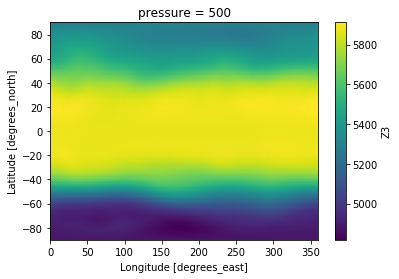

In [14]:
ds.Z3.mean(dim='time').plot()

In [12]:
pattern

'/global/cscratch1/sd/crjones/for_fengfei/e3sm-mmf/earlyscience.som.FC5AV1C-H01A.ne120.sp1_64x1_1000m.0002-03-01-00000.ncearlyscience.som.FC5AV1C-H01A.ne120.sp1_64x1_1000m.0002*.nc'

# Process 3d output for SOM

Requires zonal and meridional winds at 200hPa, 500hPa and 925hPa, and specific humidity at (925 hPa and 500 hPa).
 1. Interpolate in pressure to get those variables
 2. Write out new dataset with only the output variables there
 3. Remap afterwards

In [1]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
from numba import njit

In [ ]:
# read U, V, Q, from h2 files; ps from h1 file

In [2]:
ds3 = xr.open_dataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science/3hourly_3d_hist/earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m.20190329.cam.h2.0002-05-15-00000.nc', chunks={'time': 1})
ds2 = xr.open_dataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science/hourly_2d_hist/earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m.20190329.cam.h1.0002-05-15-00000.nc')

In [3]:
interp_levels = [200, 500, 925]
interp_q = [500, 925]
u = ds3['U']
v = ds3['V']
q = ds3['Q']

In [4]:
ps = ds2['PS'].sel(time=ds3.time)
hyam = ds3['hyam'].load()
hybm = ds3['hybm'].load()
p0 = 1000

In [5]:
# can I use dask.apply_along_axis?
p = ps * hybm / 100 + p0 * hyam
p.shape

(40, 777602, 72)

In [6]:
u = u.load()

In [7]:
u = u.transpose(*p.dims)

## Numba version

In [6]:
# For a single array
@njit
def nplev_linear_weights(p, levs=[250, 500, 925]):
    inds = np.empty((len(levs), 2), dtype=np.int64)
    weights = np.empty((len(levs), 2), dtype=np.float64)
    for n, ll in enumerate(levs):
        iup = np.searchsorted(p, ll, side='right')
        if iup == 0 or iup >= len(p):
            inds[n] = (0, 0)
            weights[n] = (np.nan, np.nan)
            continue
        idn = iup - 1
        dp = (ll - p[idn]) / (p[iup] - p[idn])
        inds[n] = (idn, iup)
        weights[n] = (1 - dp, dp)
    return inds, weights

@njit
def napply_weights_to_column(v, inds, weights):
    return np.array([np.sum(v[inds[k]] * weights[k]) for k in range(len(inds))])

@njit
def ninterp_col_to_pres_level(p, levs, da):
    shape = (*p.shape[:-1], len(levs))
    # outx = np.full(shape, fill_value=np.nan)
    outx = np.empty(shape)
    for ind in np.ndindex(p.shape[:-1]):
        inds, weights = nplev_linear_weights(p[ind], levs)
        outx[ind] = napply_weights_to_column(da[ind], inds, weights)
    return outx

In [7]:
# For calculating weights and applying to several arrays:
@njit
def nplev_linear_weights(p, levs=[250, 500, 925]):
    inds = np.empty((len(levs), 2), dtype=np.int64)
    weights = np.empty((len(levs), 2), dtype=np.float64)
    for n, ll in enumerate(levs):
        iup = np.searchsorted(p, ll, side='right')
        if iup == 0 or iup >= len(p):
            inds[n] = (0, 0)
            weights[n] = (np.nan, np.nan)
            continue
        idn = iup - 1
        dp = (ll - p[idn]) / (p[iup] - p[idn])
        inds[n] = (idn, iup)
        weights[n] = (1 - dp, dp)
    return inds, weights

@njit
def nplev_all_weights(p, levs):
    nlev = len(levs)
    p_indices = np.empty((*p.shape[:-1], nlev, 2), dtype=np.int64)
    p_weights = np.empty((*p.shape[:-1], nlev, 2), dtype=np.float64)
    for ind in np.ndindex(p.shape[:-1]):
        p_indices[ind], p_weights[ind] = nplev_linear_weights(p[ind], levs)
    return p_indices, p_weights

@njit
def napply_weights_to_array(p_inds, p_weights, arr):
    # arr should have same shape
    shape = (*arr.shape[:-1], p_inds.shape[-2])
    out = np.empty(shape, dtype=np.float64)
    for ind in np.ndindex(arr.shape[:-1]):
        out[ind] = napply_weights_to_column(arr[ind], p_inds[ind], p_weights[ind])
    return out

## Test with dummy data
Everything here checks out

In [5]:
# Do some tests to validate whether these two are the same ...
ptest = np.arange(0, 1100, 100)
levs = np.array([250, 500, 925])
npres = len(ptest)
nlevs = len(levs)

In [15]:
pdata = np.broadcast_to(ptest, (ntime, ncol, npres))
pdata.shape

(20, 1000, 11)

In [17]:
pdata[0:3, 0, :]

array([[   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000],
       [   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000],
       [   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]])

In [10]:
ntime = 20
ncol = 1000
rand_data = np.random.rand(ntime, ncol, npres)
lin_data = np.arange(ntime * ncol * npres).reshape((ntime, ncol, npres))
pdata = np.broadcast()
rand_data.shape

(20, 1000, 11)

In [18]:
%%time
# v0 test:
rand_interp0 = ninterp_col_to_pres_level(pdata, levs, rand_data)
lin_interp0 = ninterp_col_to_pres_level(pdata, levs, lin_data)

CPU times: user 1.78 s, sys: 14.8 ms, total: 1.8 s
Wall time: 1.8 s


In [19]:
%%time 
# v1 test:
pind, pwt = nplev_all_weights(pdata, levs)
rand_interp1 = napply_weights_to_array(pind, pwt, rand_data)
lin_interp1 = napply_weights_to_array(pind, pwt, lin_data)

CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 1.11 s


In [33]:
print(np.all(rand_interp1 == rand_interp0))
print(np.all(lin_interp1 == lin_interp0))

True
True


In [32]:
lin_interp0[:, 0, :]

array([[2.5000000e+00, 5.0000000e+00, 9.2500000e+00],
       [1.1002500e+04, 1.1005000e+04, 1.1009250e+04],
       [2.2002500e+04, 2.2005000e+04, 2.2009250e+04],
       [3.3002500e+04, 3.3005000e+04, 3.3009250e+04],
       [4.4002500e+04, 4.4005000e+04, 4.4009250e+04],
       [5.5002500e+04, 5.5005000e+04, 5.5009250e+04],
       [6.6002500e+04, 6.6005000e+04, 6.6009250e+04],
       [7.7002500e+04, 7.7005000e+04, 7.7009250e+04],
       [8.8002500e+04, 8.8005000e+04, 8.8009250e+04],
       [9.9002500e+04, 9.9005000e+04, 9.9009250e+04],
       [1.1000250e+05, 1.1000500e+05, 1.1000925e+05],
       [1.2100250e+05, 1.2100500e+05, 1.2100925e+05],
       [1.3200250e+05, 1.3200500e+05, 1.3200925e+05],
       [1.4300250e+05, 1.4300500e+05, 1.4300925e+05],
       [1.5400250e+05, 1.5400500e+05, 1.5400925e+05],
       [1.6500250e+05, 1.6500500e+05, 1.6500925e+05],
       [1.7600250e+05, 1.7600500e+05, 1.7600925e+05],
       [1.8700250e+05, 1.8700500e+05, 1.8700925e+05],
       [1.9800250e+05, 1.980

In [31]:
lin_data[:, 0, :]

array([[     0,      1,      2,      3,      4,      5,      6,      7,
             8,      9,     10],
       [ 11000,  11001,  11002,  11003,  11004,  11005,  11006,  11007,
         11008,  11009,  11010],
       [ 22000,  22001,  22002,  22003,  22004,  22005,  22006,  22007,
         22008,  22009,  22010],
       [ 33000,  33001,  33002,  33003,  33004,  33005,  33006,  33007,
         33008,  33009,  33010],
       [ 44000,  44001,  44002,  44003,  44004,  44005,  44006,  44007,
         44008,  44009,  44010],
       [ 55000,  55001,  55002,  55003,  55004,  55005,  55006,  55007,
         55008,  55009,  55010],
       [ 66000,  66001,  66002,  66003,  66004,  66005,  66006,  66007,
         66008,  66009,  66010],
       [ 77000,  77001,  77002,  77003,  77004,  77005,  77006,  77007,
         77008,  77009,  77010],
       [ 88000,  88001,  88002,  88003,  88004,  88005,  88006,  88007,
         88008,  88009,  88010],
       [ 99000,  99001,  99002,  99003,  99004,  99005,

## Test both approaches on real model output
Seems like time is dominated by loading the array into memory in the first place. Both versions seem pretty comparable in terms of evaluation time, so no need to use the last.

In [13]:
ud = u.transpose(*p.dims)
vd = v.transpose(*p.dims)
qd = q.transpose(*p.dims)

In [15]:
%%time
# v0 test:
levs = np.array([200, 500, 925])
uinterp0 = ninterp_col_to_pres_level(p.values, levs, ud.values)
vinterp0 = ninterp_col_to_pres_level(p.values, levs, vd.values)

CPU times: user 1min 46s, sys: 28 s, total: 2min 14s
Wall time: 2min 21s


In [17]:
%%time
# procedure:
levs = np.array([200, 500, 925])
pind, pwt = nplev_all_weights(p.values, levs)   # find weights and indices first
uinterp = napply_weights_to_array(pind, pwt, ud.values)   # apply to u
vinterp = napply_weights_to_array(pind, pwt, vd.values)   # apply to v
# qinterp = napply_weights_to_array(pind, pwt, qd.values)   # apply to q

CPU times: user 1min 43s, sys: 42.7 s, total: 2min 25s
Wall time: 2min 40s


In [18]:
# verify output is same between two versions
print(np.all(uinterp0 == uinterp))
print(np.all(vinterp0 == vinterp))

False
False


In [49]:
np.unique(np_inds)

array([2])

In [56]:
# hypothesis: nans occur because the bottom level is higher than the interpolation lev
tinds, ncol_inds, np_inds = np.where(np.isnan(uinterp0))  # hypothesis: surface pressure is lower than 925 at these locations
vals = np.unique(ps.where(np.isnan(uinterp0[:, :, -1])))

In [61]:
np.nanmax(vals)

92639.28

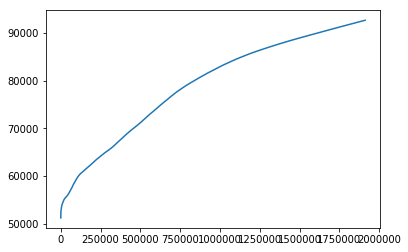

In [57]:
plt.plot(vals)

In [37]:
np.count_nonzero(np.isnan(uinterp0)) == np.count_nonzero(np.isnan(uinterp)) == np.count_nonzero(uinterp0 != uinterp)

True

In [29]:
def naneq(a, b):
    """ Returns true if a == b or if both a and b are np.nan"""
    return np.logical_or(a == b, np.logical_and(np.isnan(a), np.isnan(b)))

In [34]:
# validated -- there are a number of nans, all the 925 hPa index, all corresponding to ps > 926 hPa.
# both versions give the same answer and the same locations of nans at each location
print(np.all(naneq(uinterp0, uinterp)))
print(np.all(naneq(vinterp0, vinterp)))

True
True


## Spin this into a full on method

In [71]:
time = ds3.time
ncol = ds3.ncol

In [73]:
time

<xarray.DataArray 'time' (time: 40)>
array([cftime.DatetimeNoLeap(2, 5, 15, 0, 0, 0, 0, 3, 135),
       cftime.DatetimeNoLeap(2, 5, 15, 3, 0, 0, 0, 3, 135),
       cftime.DatetimeNoLeap(2, 5, 15, 6, 0, 0, 0, 3, 135),
       cftime.DatetimeNoLeap(2, 5, 15, 9, 0, 0, 0, 3, 135),
       cftime.DatetimeNoLeap(2, 5, 15, 12, 0, 0, 0, 3, 135),
       cftime.DatetimeNoLeap(2, 5, 15, 15, 0, 0, 0, 3, 135),
       cftime.DatetimeNoLeap(2, 5, 15, 18, 0, 0, 0, 3, 135),
       cftime.DatetimeNoLeap(2, 5, 15, 21, 0, 0, 0, 3, 135),
       cftime.DatetimeNoLeap(2, 5, 16, 0, 0, 0, 0, 4, 136),
       cftime.DatetimeNoLeap(2, 5, 16, 3, 0, 0, 0, 4, 136),
       cftime.DatetimeNoLeap(2, 5, 16, 6, 0, 0, 0, 4, 136),
       cftime.DatetimeNoLeap(2, 5, 16, 9, 0, 0, 0, 4, 136),
       cftime.DatetimeNoLeap(2, 5, 16, 12, 0, 0, 0, 4, 136),
       cftime.DatetimeNoLeap(2, 5, 16, 15, 0, 0, 0, 4, 136),
       cftime.DatetimeNoLeap(2, 5, 16, 18, 0, 0, 0, 4, 136),
       cftime.DatetimeNoLeap(2, 5, 16, 21, 0, 0, 0, 4, 1

In [69]:
lev_da = xr.DataArray(levs, coords=[levs], dims=['pressure'], attrs={'units': 'hPa', 'long_name': 'pressure'}, name='pressure')
lev_da

<xarray.DataArray 'pressure' (pressure: 3)>
array([200, 500, 925])
Coordinates:
  * pressure  (pressure) int64 200 500 925
Attributes:
    units:      hPa
    long_name:  pressure

In [74]:
u_out = xr.DataArray(uinterp, coords=[time, ncol, lev_da], dims=['time', 'ncol', 'pressure'], name=ds3.U.name, attrs=ds3.U.attrs)
u_out

<xarray.DataArray 'U' (time: 40, ncol: 777602, pressure: 3)>
array([[[67.069111, 34.081723,  6.021814],
        [67.566691, 34.81158 ,  6.625131],
        ...,
        [68.725575, 37.707305, 11.397061],
        [67.921358, 37.075431, 11.656846]],

       [[66.078288, 31.028062,  5.402175],
        [65.972813, 32.214642,  6.022508],
        ...,
        [68.788646, 37.904885, 11.594776],
        [68.078061, 36.53091 , 11.02534 ]],

       ...,

       [[57.500169, 24.661796, -4.054779],
        [57.187605, 23.941899, -4.326215],
        ...,
        [30.118643, 15.066445,  9.141085],
        [30.928864, 14.922249,  9.813946]],

       [[56.647421, 27.672616,  0.736197],
        [56.961625, 27.143613,  0.414985],
        ...,
        [35.389935, 18.18317 ,  5.690621],
        [35.011899, 18.386764,  5.326183]]])
Coordinates:
  * time      (time) object 0002-05-15 00:00:00 ... 0002-05-19 21:00:00
  * ncol      (ncol) int64 0 1 2 3 4 5 ... 777597 777598 777599 777600 777601
  * pressure  (

In [84]:
def interp_and_prep_dataset(p, levs, ds, variables=['U', 'V', 'Q']):
    time = ds.time
    ncol = ds.ncol
    pres = xr.DataArray(levs, coords=[levs], dims=['pressure'], attrs={'units': 'hPa', 'long_name': 'pressure'}, name='pressure')
    out_dict = {}
    for v in variables:
        da = ds[v].transpose(*p.dims)
        interp = ninterp_col_to_pres_level(p.values, levs, da.values)
        out_dict[v] = xr.DataArray(interp, coords=[time, ncol, pres],
                                   dims=['time', 'ncol', 'pressure'],
                                   name=ds[v].name, attrs=ds[v].attrs)
    return xr.Dataset(out_dict, attrs=ds3.attrs)

In [96]:
%%time
ds = interp_and_prep_dataset(p, levs, ds3, variables=['U', 'V', 'Q'])
ds.to_netcdf()

CPU times: user 2min 40s, sys: 59.7 s, total: 3min 39s
Wall time: 3min 52s


In [102]:
ds = ds.transpose('time', 'pressure', 'ncol')
ds.attrs = ds3.attrs

In [103]:
ds

<xarray.Dataset>
Dimensions:   (ncol: 777602, pressure: 3, time: 40)
Coordinates:
  * time      (time) object 0002-05-15 00:00:00 ... 0002-05-19 21:00:00
  * ncol      (ncol) int64 0 1 2 3 4 5 ... 777597 777598 777599 777600 777601
  * pressure  (pressure) int64 200 500 925
Data variables:
    U         (time, pressure, ncol) float64 67.07 67.57 68.54 ... 5.691 5.326
    V         (time, pressure, ncol) float64 23.94 24.26 24.78 ... 3.035 2.758
    Q         (time, pressure, ncol) float64 2.357e-05 2.117e-05 ... 0.005654
Attributes:
    ne:                120
    np:                4
    Conventions:       CF-1.0
    source:            CAM
    case:              earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m.20190329
    title:             UNSET
    logname:           crjones
    host:              
    Version:           $Name$
    revision_Id:       $Id$
    initial_file:      earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m.2019032...
    topography_file:   /gpfs/alpine/world-shared/c

In [106]:
[v for v in ds.data_vars]

['U', 'V', 'Q']

In [153]:
# comp = {'zlib': True, 'complevel': 5, 'dtype': 'float32', '_FillValue': 1.0e36}
comp = {'dtype': 'float32', '_FillValue': -9999.0}
encoding = {v: comp for v in ds.data_vars}
encoding

{'U': {'dtype': 'float32', '_FillValue': -9999.0},
 'V': {'dtype': 'float32', '_FillValue': -9999.0},
 'Q': {'dtype': 'float32', '_FillValue': -9999.0}}

In [154]:
ds.to_netcdf('/global/cscratch1/sd/crjones/test_out6.nc', encoding=encoding)

In [155]:
ds_a = xr.open_dataset('/global/cscratch1/sd/crjones/test_out5.remap.nc')
ds_b = xr.open_dataset('/global/cscratch1/sd/crjones/test_out6.remap.nc')

In [156]:
np.all(naneq(ds_a, ds_b))

<xarray.Dataset>
Dimensions:   ()
Data variables:
    lat_bnds  bool True
    lon_bnds  bool True
    gw        bool True
    area      bool True
    Q         bool True
    U         bool True
    V         bool True
    ncol      bool True

In [149]:
ds_x = xr.open_dataset('/global/cscratch1/sd/crjones/test_out5.nc')
ds_y = xr.open_dataset('/global/cscratch1/sd/crjones/test_out4.nc')

In [152]:
np.all(naneq(ds_x, ds_y))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    U        bool True
    V        bool True
    Q        bool True

In [134]:
tmp = ds_a.Q.where(~naneq(ds_a.Q.values, ds_b.Q.values)).values
tmp2 = ds_b.Q.where(~naneq(ds_a.Q.values, ds_b.Q.values)).values

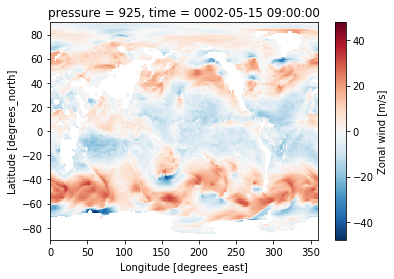

In [148]:
(ds_b.U).isel(time=3, pressure=2).plot()

In [120]:
np.all(ds_a == ds_b)

<xarray.Dataset>
Dimensions:   ()
Data variables:
    lat_bnds  bool True
    lon_bnds  bool True
    gw        bool True
    area      bool True
    Q         bool False
    U         bool False
    V         bool False
    ncol      bool True

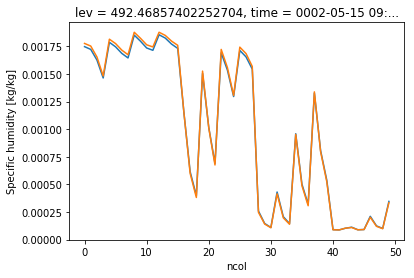

In [95]:
ds.Q.isel(time=3, pressure=1).plot()
ds3.Q.sel(lev=500, method='nearest').isel(time=3, ncol=range(0, 50)).plot()

## Overall: validation complete
Takeaways:
 * numba is necessary for this not to go crazy slow
 * there are a lot of "nans" to worry about at the lowest pressure level
 * converting back to float32 (filesize) and explicitly setting _FillValue is important for remapping